# Machine Learning - Practical 4 - Deep Learning VS Trees


Names: {Lars Kaesberg, Luca Francis, Matthias Mildenberger}
Summer Term 2023   
Due Date: Tuesday, June 13, 2pm

In this practical we are going to use a tabular dataset. We will test two different approaches - forests and neural networks and compare performance. We are also going to learn how to make trees interpretable.

To prepare this tutorial we used [this paper](https://arxiv.org/pdf/2207.08815.pdf) with its [repository](https://github.com/LeoGrin/tabular-benchmark).

For explained variance in trees, you can read more [here](https://scikit-learn.org/0.15/auto_examples/ensemble/plot_gradient_boosting_regression.html#example-ensemble-plot-gradient-boosting-regression-py).


In [1]:
import time

import sklearn.metrics
%matplotlib inline

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pickle
import os
from pandas.api.types import is_numeric_dtype
from pandas.api.types import is_categorical_dtype

from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import recall_score, precision_score, accuracy_score

from PIL import Image
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, Subset
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchvision.utils import make_grid

torch.manual_seed(42)  # Set manual seed
from fastprogress.fastprogress import force_console_behavior

master_bar, progress_bar = force_console_behavior()

In [2]:
# DO NOT CHANGE
use_cuda = True
use_cuda = False if not use_cuda else torch.cuda.is_available()
device = torch.device('cuda:0' if use_cuda else 'cpu')
torch.cuda.get_device_name(device) if use_cuda else 'cpu'
print('Using device', device)

Using device cuda:0


## Load, clean and split the tabular dataset

We use the preprocessing pipeline from [Grinsztajn, 2022](https://arxiv.org/pdf/2207.08815.pdf).

**No missing data**    

Remove all rows containing at least one missing entry.    

*In practice people often do not remove rows with missing values but try to fill missing values in a column with the mean or median values for numerical data and mode or median values for categorical data. Sometimes even simple prediction models are used to fill in the gaps but we will remove rows or columns with missing values for the sake of simplicity*

**Balanced classes**   

For classification, the target is binarised if there are multiple classes, by taking the two most numerous classes, and we keep half of samples in each class.

**Low cardinality categorical features**   

Remove categorical features with more than 20 items. 

**High cardinality numerical features**   

Remove numerical features with less than 10 unique values. Convert numerical features with 2 unique values to categorical.

**Data description:**  
Data reported to the police about the circumstances of personal injury road accidents in Great Britain from 1979. This version includes data up to 2015. We will try to predict the sex of the driver based on the data provided.

In [3]:
## In case you have any issues with loading the pickle file
## check that your pandas version is 1.4.1
## or just simply run:
## pip install pandas==1.4.1

with open('data/adopted_road_safety.pkl', 'rb') as f:
    dataset = pickle.load(f)

In [4]:
dataset

Accident_Index  Vehicle_Reference_df_res  Vehicle_Type  \
0       201501BS70001                         1          19.0   
1       201501BS70002                         1           9.0   
2       201501BS70004                         1           9.0   
3       201501BS70005                         1           9.0   
4       201501BS70008                         1           1.0   
...               ...                       ...           ...   
363238  2015984141415                        13           9.0   
363239  2015984141415                        13           9.0   
363240  2015984141415                        13           9.0   
363241  2015984141415                        13           9.0   
363242  2015984141415                        13           9.0   

        Towing_and_Articulation  Vehicle_Manoeuvre  \
0                           0.0                9.0   
1                           0.0                9.0   
2                           0.0                9.0   
3                           0.0                9.0   
4                           0.0               18.0   
...                         ...                ...   
363238                      0.0               18.0   
363239                      0.0               18.0   
363240                      0.0               18.0   
363241                      0.0               18.0   
363242                      0.0               18.0   

        Vehicle_Location-Restricted_Lane  Junction_Location  \
0                                    0.0                8.0   
1                                    0.0                8.0   
2                                    0.0                2.0   
3                                    0.0                2.0   
4                                    0.0                8.0   
...                                  ...                ...   
363238                               0.0                0.0   
363239                               0.0                0.0   
363240                               0.0                0.0   
363241                               0.0                0.0   
363242                               0.0                0.0   

        Skidding_and_Overturning  Hit_Object_in_Carriageway  \
0                            0.0                        0.0   
1                            0.0                        0.0   
2                            0.0                        0.0   
3                            0.0                        0.0   
4                            0.0                        0.0   
...                          ...                        ...   
363238                       0.0                        0.0   
363239                       0.0                        0.0   
363240                       0.0                        0.0   
363241                       0.0                        0.0   
363242                       0.0                        0.0   

        Vehicle_Leaving_Carriageway  ...  Age_Band_of_Casualty  \
0                               0.0  ...                   7.0   
1                               0.0  ...                   5.0   
2                               0.0  ...                   6.0   
3                               0.0  ...                   2.0   
4                               0.0  ...                   8.0   
...                             ...  ...                   ...   
363238                          5.0  ...                   1.0   
363239                          5.0  ...                   5.0   
363240                          5.0  ...                   4.0   
363241                          5.0  ...                   6.0   
363242                          5.0  ...                   4.0   

        Casualty_Severity  Pedestrian_Location  Pedestrian_Movement  \
0                       3                  5.0                  1.0   
1                       3                  9.0                  9.0   
2                       3                  1.0           

In [5]:
target_column = 'Sex_of_Driver'
test_size = 0.2
random_state = 42

In [6]:
def remove_nans(df: pd.DataFrame):
    '''
    this function removes rows with nans
    '''
    return df.dropna()


def numerical_to_categorical(df: pd.DataFrame, n=2, ignore=[target_column]):
    '''
    change the type of the column to categorical 
    if it has <= n unique values
    '''
    for column in df.columns:
        if column in ignore:
            continue
        if df[column].nunique() <= n:
            df[column] = df[column].astype('category')
    return df


def remove_columns_by_n(df, n=10, condition=np.number, direction='less',
                        ignore=[target_column]):
    '''
   
    Remove columns with more or less than n unique values. 
    Usually it makes sense to apply this function to columns with categorical values (see below where it is called).
    With the default values we remove all numerical columns which have less than 10 unique values (except for the target_column).
    '''
    for column in df.columns:
        if column in ignore:
            continue
        if condition == np.number and not is_numeric_dtype(df[column]):
            continue
        if condition == 'categorical' and not is_categorical_dtype(df[column]):
            continue

        if direction == 'less' and df[column].nunique() < n:
            df.drop(column, axis=1, inplace=True)
        if direction == 'more' and df[column].nunique() > n:
            df.drop(column, axis=1, inplace=True)
    return df

In [7]:
df = dataset.copy()
df = remove_nans(df)
df = numerical_to_categorical(df, n=2, ignore=[target_column])
df = remove_columns_by_n(df, n=10, condition=np.number, direction='less',
                         ignore=[target_column])
df = remove_columns_by_n(df, n=40, condition='category', direction='more',
                         ignore=[target_column])
assert not df.isna().any().any(), 'There are still nans in the dataframe'

In [8]:
# expected results variable names - train_X, test_X, train_y, test_y

X = df.drop(target_column, axis=1)
Y = df[target_column]

train_X, test_X, train_y, test_y = train_test_split(X, Y, test_size=test_size, random_state=random_state)

** :**

* Did you split the dataset in a stratified manner or not? Why?
*   No, as we do not choose the datapoints based on feature occurrence count.
* How did the dataset dimensions change after preprocessing?
*   Many datapoints, that we deem unfit, are removed, therefore, the dataset dimensions are smaller after preprocessing
* How many unique values are in the response variable?
*   3

In [9]:
dataset.shape

(363243, 67)

In [10]:
df.shape

(96326, 18)

In [11]:
df[target_column].value_counts()

Sex_of_Driver
1.0    63072
2.0    33101
3.0      153
Name: count, dtype: int64

## Task 1: Create a GradientBoostingClassifier

In [12]:
## train it on the train set and predict on the test set
classifier = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=random_state)
classifier.fit(train_X, train_y)
y_pred = classifier.predict(test_X)

In [13]:
## Hint : use functions from sklearn metrics
print('Accuracy \tPrecision \tRecall')
print(accuracy_score(test_y, y_pred), precision_score(test_y, y_pred, average='micro'),
      recall_score(test_y, y_pred, average='micro'))

Accuracy 	Precision 	Recall
0.7427592650264715 0.7427592650264715 0.7427592650264715


In [14]:
## train a classifier with a specified amount of trees and print accuracy, precision, and recall.
## Note: the calculations may take several minutes (depending on the computer efficiency).

def trees_amount_exploration(train_X, train_y, test_X, test_y, trees_amount=[1, 20, 50, 100]):
    for amount in trees_amount:
        classifier = GradientBoostingClassifier(n_estimators=amount, learning_rate=1.0, max_depth=1,
                                                random_state=random_state)
        classifier.fit(train_X, train_y)
        y_pred = classifier.predict(test_X)
        print('Amount', amount)
        print('Accuracy', accuracy_score(test_y, y_pred))
        print('Precision', precision_score(test_y, y_pred, average='micro'))
        print('Recall', recall_score(test_y, y_pred, average='micro'))
        print()


In [15]:
trees_amount_exploration(train_X, train_y, test_X, test_y)

Amount 1
Accuracy 0.7019101006955258
Precision 0.7019101006955258
Recall 0.7019101006955258

Amount 20
Accuracy 0.7403197342468597
Precision 0.7403197342468597
Recall 0.7403197342468597

Amount 50
Accuracy 0.7434340288591301
Precision 0.7434340288591301
Recall 0.7434340288591301

Amount 100
Accuracy 0.7427592650264715
Precision 0.7427592650264715
Recall 0.7427592650264715



In [16]:
## train a classifier with a specified amount of trees and print accuracy, precision, and recall.
## Note: the calculations may take several minutes (depending on the computer efficiency).

def learning_rate_exploration(train_X, train_y, test_X, test_y, learning_rates=[0.1, 0.2, 0.3, 0.4, 0.5],
                              trees_amount=100):
    for lr in learning_rates:
        classifier = GradientBoostingClassifier(n_estimators=trees_amount, learning_rate=lr, max_depth=1,
                                                random_state=random_state)
        classifier.fit(train_X, train_y)
        y_pred = classifier.predict(test_X)
        print('Learning Rate', lr)
        print('Accuracy', accuracy_score(test_y, y_pred))
        print('Precision', precision_score(test_y, y_pred, average='micro'))
        print('Recall', recall_score(test_y, y_pred, average='micro'))
        print()

In [17]:
learning_rate_exploration(train_X, train_y, test_X, test_y)

Learning Rate 0.1
Accuracy 0.7385030623897021
Precision 0.7385030623897021
Recall 0.7385030623897021

Learning Rate 0.2
Accuracy 0.738295442748884
Precision 0.738295442748884
Recall 0.738295442748884

Learning Rate 0.3
Accuracy 0.7400602096958372
Precision 0.7400602096958372
Recall 0.7400602096958372

Learning Rate 0.4
Accuracy 0.7408906882591093
Precision 0.7408906882591093
Recall 0.7408906882591093

Learning Rate 0.5
Accuracy 0.7416692619121769
Precision 0.7416692619121769
Recall 0.7416692619121769



In [18]:
## train a classifier with a specified depth and print accuracy, precision, and recall
## Set trees_amount= 50 to make the calculations faster
## Note: the calculations may take several minutes (depending on the computer efficiency).

def max_depth_exploration(train_X, train_y, test_X, test_y, depths=[1, 2, 3, 5]):
    for depth in depths:
        classifier = GradientBoostingClassifier(n_estimators=50, learning_rate=1.0, max_depth=depth,
                                                random_state=random_state)
        classifier.fit(train_X, train_y)
        y_pred = classifier.predict(test_X)
        print('Depth', depth)
        print('Accuracy', accuracy_score(test_y, y_pred))
        print('Precision', precision_score(test_y, y_pred, average='micro'))
        print('Recall', recall_score(test_y, y_pred, average='micro'))
        print()

In [19]:
max_depth_exploration(train_X, train_y, test_X, test_y)

Depth 1
Accuracy 0.7434340288591301
Precision 0.7434340288591301
Recall 0.7434340288591301

Depth 2
Accuracy 0.751738814491851
Precision 0.751738814491851
Recall 0.751738814491851

Depth 3
Accuracy 0.7553202532959618
Precision 0.7553202532959618
Recall 0.7553202532959618

Depth 5
Accuracy 0.7616526523409114
Precision 0.7616526523409114
Recall 0.7616526523409114



**TODO :**   

* How does the max_depth parameter influence the results?
*   More == Better
* How does the learning rate influence the results?
*   More == Slightly Better
* How does the number of trees in the ensemble influence the results?
*   There seems to be a sweetspot between 50 and 100 trees, as the performance degrades with 100 tress in regards to the performance of 50
* Try to improve the accuracy by combining different max_depth, learning rate and number of trees. How well does your best model perform?
*   Combining the best parameters let to the best results (0.768)

In [46]:
classifier = GradientBoostingClassifier(n_estimators=50, learning_rate=0.5, max_depth=5,
                                                random_state=random_state)
classifier.fit(train_X, train_y)
y_pred = classifier.predict(test_X)
print('Accuracy', accuracy_score(test_y, y_pred))
print('Precision', precision_score(test_y, y_pred, average='micro'))
print('Recall', recall_score(test_y, y_pred, average='micro'))
print()

Accuracy 0.7679850513858612
Precision 0.7679850513858612
Recall 0.7679850513858612



In [20]:

## make a plot, to show relative importance (maximum is 1) of your classifier and
## order features from most relevant feature to the least relevant in the plot

def plot_explained_variance(clf, X):
    data = sorted(zip(list(clf.feature_importances_), list(X.columns)), key=lambda z: z[0])
    data_points = [x[0] for x in data]
    columns = [x[1] for x in data]
    print(data_points, columns)
    plt.barh(columns, data_points)


[0.0, 1.5288519520722103e-07, 9.5024278821611e-05, 0.00022248458149758078, 0.0003389873552673873, 0.0007437151962076359, 0.0021423833700678556, 0.004312608453990065, 0.005019762020687714, 0.005987467616351036, 0.009698810360578286, 0.011763476294867806, 0.013537110018216348, 0.015185664848654055, 0.01636756531539944, 0.2617462894791397, 0.6528384979250582] ['Hit_Object_in_Carriageway', 'Urban_or_Rural_Area', 'Was_Vehicle_Left_Hand_Drive?', 'Pedestrian_Movement', 'Vehicle_Location-Restricted_Lane', 'Hit_Object_off_Carriageway', 'Casualty_IMD_Decile', 'Pedestrian_Location', 'Casualty_Reference', 'Number_of_Casualties', 'Age_Band_of_Casualty', 'Police_Force', 'Vehicle_Manoeuvre', 'Age_Band_of_Driver', 'Casualty_Type', 'Vehicle_Type', 'Sex_of_Casualty']


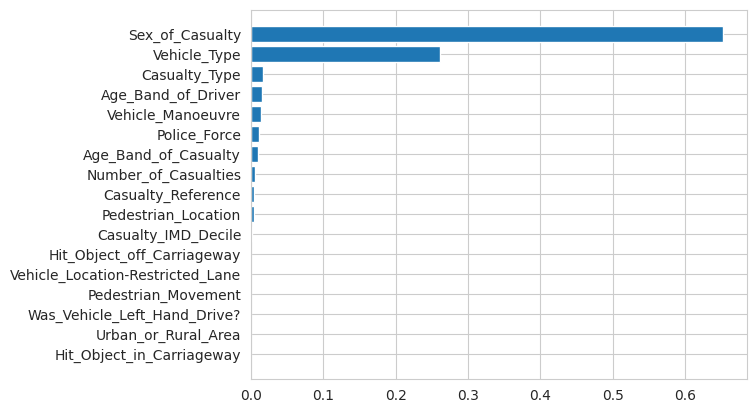

In [21]:
plot_explained_variance(classifier, train_X)

**TODO :** Interpret the plot.

The Sex of Casualty obviously heavily correlates with the Sex of the Driver, as does the Vehicle type. Other Features also contribute, but a lot less.

**TODO (optional):** Try to remove the least-important features and see what happens. Does to quality improve or degrade? Why?

## Prepare for deep learning
### Add all the necessary training functions 
*You can reuse them from previous practical exercises*

In [22]:

def accuracy(correct, total):
    """
    function to calculate the accuracy given the
        correct: number of correctly classified samples
        total: total number of samples
    returns the ratio
    """
    return float(correct) / total

In [23]:
def train(dataloader, optimizer, model, loss_fn, device, master_bar):
    """Run one training epoch.

    Args:
        dataloader (DataLoader): Torch DataLoader object to load data
        optimizer: Torch optimizer object
        model (nn.Module): Torch model to train
        loss_fn: Torch loss function
        device (torch.device): Torch device to use for training
        master_bar (fastprogress.master_bar): Will be iterated over for each
            epoch to draw batches and display training progress

    Returns:
        float, float: Mean loss of this epoch, fraction of correct predictions
            on training set (accuracy)
    """
    epoch_loss = []
    epoch_correct, epoch_total = 0, 0

    for x, y in progress_bar(dataloader, parent=master_bar):
        optimizer.zero_grad()
        model.train()

        # Forward pass
        y_pred = model(x.to(device))

        # For calculating the accuracy, save the number of correctly classified
        # images and the total number
        epoch_correct += sum(y.to(device) == y_pred.argmax(dim=1))
        epoch_total += len(y)

        # Compute loss
        loss = loss_fn(y_pred, y.to(device))

        # Backward pass
        loss.backward()
        optimizer.step()

        # For plotting the train loss, save it for each sample
        epoch_loss.append(loss.item())

    # Return the mean loss and the accuracy of this epoch
    return np.mean(epoch_loss), accuracy(epoch_correct, epoch_total)


def validate(dataloader, model, loss_fn, device, master_bar):
    """Compute loss, accuracy and confusion matrix on validation set.

    Args:
        dataloader (DataLoader): Torch DataLoader object to load data
        model (nn.Module): Torch model to train
        loss_fn: Torch loss function
        device (torch.device): Torch device to use for training
        master_bar (fastprogress.master_bar): Will be iterated over to draw
            batches and show validation progress

    Returns:
        float, float, torch.Tensor shape (10,10): Mean loss on validation set,
            fraction of correct predictions on validation set (accuracy)
    """
    epoch_loss = []
    epoch_correct, epoch_total = 0, 0
    confusion_matrix = torch.zeros(10, 10)

    model.eval()
    with torch.no_grad():
        for x, y in progress_bar(dataloader, parent=master_bar):
            # make a prediction on validation set
            y_pred = model(x.to(device))

            # For calculating the accuracy, save the number of correctly
            # classified images and the total number
            epoch_correct += sum(y.to(device) == y_pred.argmax(dim=1))
            epoch_total += len(y)

            # Fill confusion matrix
            for (y_true, y_p) in zip(y, y_pred.argmax(dim=1)):
                confusion_matrix[int(y_true), int(y_p)] += 1

            # Compute loss
            loss = loss_fn(y_pred, y.to(device))

            # For plotting the train loss, save it for each sample
            epoch_loss.append(loss.item())

    # Return the mean loss, the accuracy and the confusion matrix
    return np.mean(epoch_loss), accuracy(epoch_correct, epoch_total), confusion_matrix



In [24]:
# - calls the train and validate functions for each epoch
# - saves the train_losses, val_losses, train_accs, val_accs as arrays for each epoch
## Hint - you can use yours from practical 3 
from tqdm import trange


def run_training(model, optimizer, loss_function, device, num_epochs,
                 train_dataloader, val_dataloader):
    """Run model training.

    Args:
        model (nn.Module): Torch model to train
        optimizer: Torch optimizer object
        loss_fn: Torch loss function for training
        device (torch.device): Torch device to use for training
        num_epochs (int): Max. number of epochs to train
        train_dataloader (DataLoader): Torch DataLoader object to load the
            training data
        val_dataloader (DataLoader): Torch DataLoader object to load the
            validation data

    Returns:
        list, list, list, list, torch.Tensor shape (10,10): Return list of train
            losses, validation losses, train accuracies, validation accuracies
            per epoch and the confusion matrix evaluated in the last epoch.
    """
    start_time = time.time()
    mb = master_bar(range(num_epochs))
    train_losses, val_losses, train_accs, val_accs = [], [], [], []

    for epoch in mb:
        # Train the model
        epoch_train_loss, epoch_train_acc = train(train_dataloader, optimizer, model,
                                                  loss_function, device, mb)
        # Validate the model
        epoch_val_loss, epoch_val_acc, confusion_matrix = validate(val_dataloader,
                                                                   model, loss_function,
                                                                   device, mb)

        # Save loss and acc for plotting
        train_losses.append(epoch_train_loss)
        val_losses.append(epoch_val_loss)
        train_accs.append(epoch_train_acc)
        val_accs.append(epoch_val_acc)

    time_elapsed = np.round(time.time() - start_time, 0).astype(int)
    print(f'Finished training after {time_elapsed} seconds.')
    return train_losses, val_losses, train_accs, val_accs, confusion_matrix

In [25]:
def calc_confusion_values(dataloader, model, device):
    """ method to compute the confusion values on the validation set """
    _, _, confusion_matrix = validate(dataloader, model, device, None)
    return confusion_matrix

In [26]:
def plot(title, label, train_results, val_results):
    epoch_array = np.arange(len(train_results)) + 1
    train_label, val_label = "Training " + label.lower(), "Validation " + label.lower()

    sns.set(style='ticks')

    plt.plot(epoch_array, train_results, epoch_array, val_results, linestyle='dashed', marker='o')
    legend = ['Train results', 'Validation results']

    plt.legend(legend)
    plt.xlabel('Epoch')
    plt.ylabel(label)
    plt.title(title)

    sns.despine(trim=True, offset=5)
    plt.title(title, fontsize=15)
    plt.show()

### Convert a pandas dataframe to a PyTorch dataset

In [27]:
## Hint : you can use/adapt your code from practical 2
class TabularDataset(torch.utils.data.Dataset):
    def __init__(self, df_x, df_y, mean=None, std=None, normalise=True):
        '''
        TODO: save params to self attributes, 
        x is data without target column
        y is target column
        transform df to_numpy
        '''
        self.x = torch.tensor(df_x.values)
        self.y = torch.tensor(df_y.values)
        self.mean = mean.values
        self.std = std.values
        self.normalise = normalise

    def __len__(self):
        return len(self.x)

    def __getitem__(self, index):
        if self.normalise:
            return (self.x[index] - self.mean) / self.std, self.y[index]
        return self.x[index], self.y[index]

In [28]:
## Hint : be careful with categorical values. Convert them them to numerical
## Hint : the response variable should be of datatype integer
train_X_num = train_X.apply(pd.to_numeric)
mean = train_X_num.mean(axis=0)
std = train_X_num.std(axis=0)

train_y_num = train_y.astype(np.number)
train_y_num = train_y_num.apply(int)
train_y_num = train_y_num - 1

test_X_num = test_X.apply(pd.to_numeric)

test_y_num = test_y.astype(np.number)
test_y_num = test_y_num.apply(int)
test_y_num = test_y_num - 1

/home/luca/machinelearning/venv/lib/python3.10/site-packages/pandas/core/dtypes/common.py:1691: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.
  npdtype = np.dtype(dtype)
/home/luca/machinelearning/venv/lib/python3.10/site-packages/pandas/core/dtypes/common.py:1691: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.
  npdtype = np.dtype(dtype)


In [29]:
# be careful with the labels, they should start from 0!
normalizes_dataset = TabularDataset(train_X_num, train_y_num, mean, std, True)
normalizes_dataset_test = TabularDataset(test_X_num, test_y_num, mean, std, True)

batch_size = 256
train_loader = torch.utils.data.DataLoader(normalizes_dataset, shuffle=True, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(normalizes_dataset_test, shuffle=True, batch_size=batch_size)

## Logistic regression

In [30]:
class LR(torch.nn.Module):
    """
    The logistic regression model inherits from torch.nn.Module 
    which is the base class for all neural network modules.
    """

    def __init__(self, input_dim, output_dim):
        """ Initializes internal Module state. """
        super(LR, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim)

    def forward(self, x):
        """ Defines the computation performed at every call. """
        # What are the dimensions of your input layer?
        x = x.to(torch.float32)
        outputs = self.linear(x)

        return outputs

In [31]:
## don't forget to move everything for the correct devices
## 
lr = 0.001
model = LR(17, 3).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
loss = torch.nn.CrossEntropyLoss()

model.train()


LR(
  (linear): Linear(in_features=17, out_features=3, bias=True)
)

In [32]:
num_epochs = 30
train_losses_lr, val_losses_lr, train_accs_lr, val_accs_lr, lr_confusion_matrix = run_training(model, optimizer, loss,
                                                                                               device, num_epochs,
                                                                                               train_loader,
                                                                                               test_loader)

 Finished training after 82 seconds.


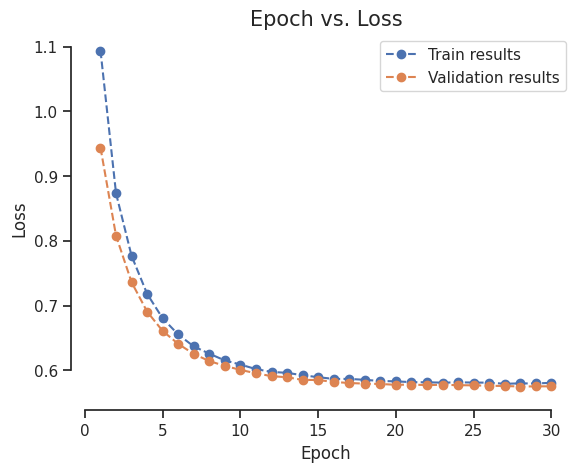

In [33]:
plot('Epoch vs. Loss', 'Loss', train_losses_lr, val_losses_lr)

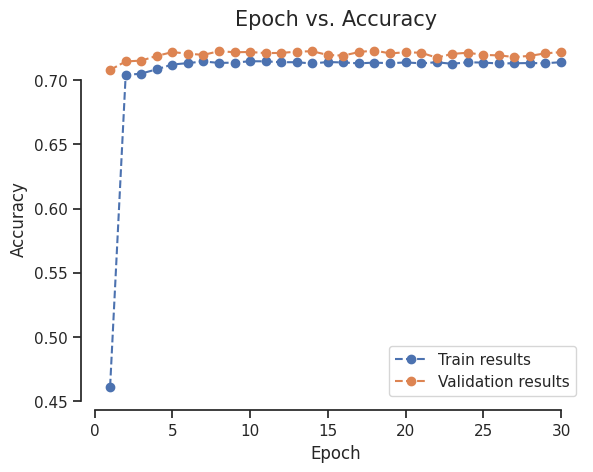

In [34]:
plot('Epoch vs. Accuracy', 'Accuracy', train_accs_lr, val_accs_lr)


## Create a simple MLP

As the default tree has 3 layers, let's make a MLP with 3 linear layers and ReLU.
Please notice that making convolutions on tabular data does not make much sense even though it is technically possible.   

**TODO :** Explain why making convolutions on tabular data does not make much sense. Why do we use an MLP, not a CNN from the previous homework?

Because the tabular data is only structured in one dimension and in this dimension the datapoint hold different meanings. Therefore, it does not make sense to convolve over the data because the data can not be combined sensibly when looking at the surrounding datapoints of a datapoint.

In [54]:
class TabularNetwork(torch.nn.Module):
    def __init__(self, input_dim, output_dim):
        """ Initializes internal Module state. """
        super(TabularNetwork, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_dim, input_dim//2),
            nn.ReLU(),
            nn.Linear(input_dim//2, output_dim),
            # To get a MLP with Layers of size input_dim, input_dim//2, output_dim, we define two connections (This feels not like it is intended)
        )

    def forward(self, x):
        """ Defines the computation performed at every call. """
        x = x.to(torch.float32)
        return self.network(x)

In [55]:
## put model to the device, and train mode
## you can optionally apply regularisation between 0.0005 and 0.005 
lr = 0.001
mlp = TabularNetwork(17, 3).to(device)
optimizer = torch.optim.Adam(mlp.parameters(), lr=lr, weight_decay=0.0005)
loss = torch.nn.CrossEntropyLoss()

In [56]:
num_epochs = 50
train_losses_mlp, val_losses_mlp, train_accs_mlp, val_accs_mlp, mlp_confusion_matrix = run_training(mlp, optimizer, loss,
                                                                                               device, num_epochs,
                                                                                               train_loader,
                                                                                               test_loader)

 Finished training after 140 seconds.


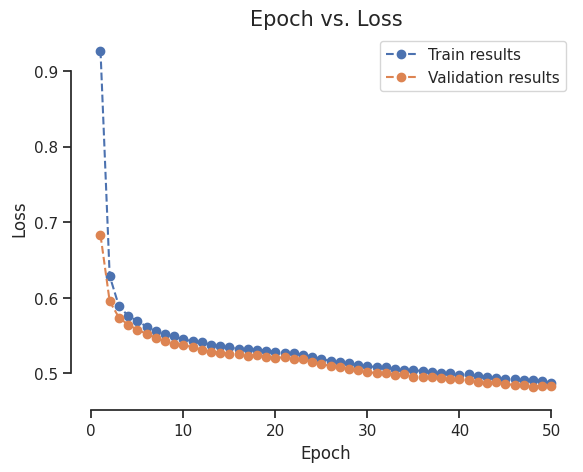

In [57]:
plot('Epoch vs. Loss', 'Loss', train_losses_mlp, val_losses_mlp)

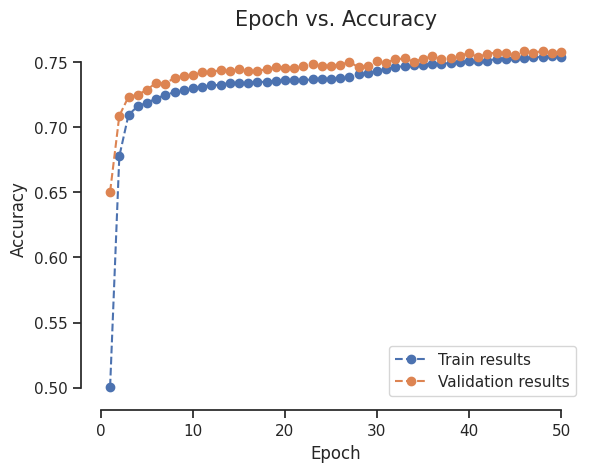

In [58]:
plot('Epoch vs. Accuracy', 'Accuracy', train_accs_mlp, val_accs_mlp)

**:** Did your network perform better or worse than the GradientBoostingClassifier on this dataset? Why?
It performed a bit worse, because we have categorical variables and trees are better at distinguishing them while MLP can only look at them from a numerical perspective.

## Bonus tasks (optional)
* Try to use SGD instead of Adam as optimiser. What do you notice?
Here are different opinions on this topic:
  * https://codeahoy.com/questions/ds-interview/33/#:~:text=Adam%20tends%20to%20converge%20faster,converges%20to%20more%20optimal%20solutions.
  * https://shaoanlu.wordpress.com/2017/05/29/sgd-all-which-one-is-the-best-optimizer-dogs-vs-cats-toy-experiment/ 
  * https://datascience.stackexchange.com/questions/30344/why-not-always-use-the-adam-optimization-technique

* Try to make your MLP twice deeper. What do you notice? Why?

## Advanced topic to read about:
**Tools which may be helpful for data exploration:**
* df.describe() - returns some basic statistics for your dataset - https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.describe.html
* ydata-profiling (previous pandas-profiling) - generates interactive data exploration report: basic statistics, nans, correlations between different features - https://github.com/ydataai/ydata-profiling

**Tree libraries**
* XGBoost - XGBoost stands for “Extreme Gradient Boosting”, where the term “Gradient Boosting” originates from the paper Greedy Function Approximation: A Gradient Boosting Machine, by Friedman. https://xgboost.readthedocs.io/en/stable/tutorials/model.html
* LightGBM - industrial library for XGBoost from Miscrosoft. LightGBM is a gradient boosting framework that uses tree based learning algorithms. It is designed to be distributed and efficient. https://lightgbm.readthedocs.io/en/v3.3.2/